### When trainingset = 300 Pos, 2000 Neg  


The baseline TF-IDF model is a VERY strong Baseline. Tim at Peltarion has previously worked with these models, so it is engineered to be a very strong baseline across multiple classification tasks.   

| Model | Accuracy | F1 Score |
| :- | -: | :-: |
| TF-IDF (baseline (word + char)) | 0.989 | 0.9661 |
| TF-IDF (baseline (word)) | 0.9752 | 0.9244 |
| TF-IDF (word + Random Forest cls) | 0.9477 | 0.8224 |
| KB-BERT | 0.962204 | 0.925067 |


In [1]:
# Train and test on 2016 data
# train = 1449 
# valid = 363 
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functools import reduce

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

np.random.seed(0)
%matplotlib inline

In [2]:
def plot_roc_curve(y_true, y_probs, figure_name=None):
    """Make ROC curve if clf model has predictons with `clf.predict_proba()`."""
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_probs[:, 1])
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='AUC (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='dashed')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('True Positive Rate', fontsize=14)
    plt.ylabel('False Positive Rate', fontsize=14)
    plt.title('')
    plt.legend(loc="lower right")
    
    if figure_name is not None:
        plt.savefig(figure_name)

In [3]:
def plot_confusion_matrix(cm, class_names, 
                          cmap=plt.cm.Blues,
                          figure_name=None,
                          title=None,
                          normalized=True,
                          all_horizontal=True):
    
    """Plot the confusion matrix for a Sklearn model."""
    
    plt.figure(figsize=(8,5))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0, fontsize=15)
    plt.yticks(tick_marks, class_names, rotation=(0 if all_horizontal else 90), fontsize=15)
    thresh = cm.max()/2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalized:
            plt.text(j, i, "{:.3f}".format(cm[i, j]), horizontalalignment="center",fontsize=15, color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:.0f}".format(cm[i, j]), horizontalalignment="center",fontsize=15, color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True Label',fontsize=20)
        plt.xlabel('Predicted Label',fontsize=20)
        
    if figure_name is not None:
        plt.savefig(figure_name)

In [4]:
df = pd.read_csv("../data/df_to_predict_fall_injuries.csv")
df.head()

,id,text,time,label,gender,age
0,21,Perfect! Looked and looked for this book. Enga...,67,0,1,67
1,22,"Good variety Easy to hard. Stolz (1997, 2010) ...",23,0,0,84
2,24,great way to teach kids classical music throug...,131,0,1,72
3,28,This is a fun read on a fun topic by an intere...,89,0,0,56
4,29,one of my mainstay devotionals This book is re...,117,0,0,76


In [5]:
splits = ["train", "valid", "test"]
split_probability = [.8, .1, .1]

if "Set" not in df.columns:
    df["Set"] = np.random.choice(splits, 
                                 p=split_probability, 
                                 size=(df.shape[0],))

# concat all the features
df["text_with_features"] = df.apply(lambda x: \
              ("Gender: " + ("Man" if x.gender == 1 else "Kvinna") + ". "  \
               + "Age: "  + str(x.age)  + ". " \
               + "Time: " + str(x.time) + ". " \
               + x.text), axis=1)

In [6]:
df.head()

,id,text,time,label,gender,age,Set,concat
0,21,Perfect! Looked and looked for this book. Enga...,67,0,1,67,train,Gender: Man. Age: 67. Time: 67. Perfect! Looke...
1,22,"Good variety Easy to hard. Stolz (1997, 2010) ...",23,0,0,84,train,Gender: Kvinna. Age: 84. Time: 23. Good variet...
2,24,great way to teach kids classical music throug...,131,0,1,72,train,Gender: Man. Age: 72. Time: 131. great way to ...
3,28,This is a fun read on a fun topic by an intere...,89,0,0,56,train,Gender: Kvinna. Age: 56. Time: 89. This is a f...
4,29,one of my mainstay devotionals This book is re...,117,0,0,76,train,Gender: Kvinna. Age: 76. Time: 117. one of my ...


In [7]:
train_indices = df[df.Set=="train"].index
valid_indices = df[df.Set=="valid"].index
test_indices = df[df.Set=="test"].index

# Reduce the number of patients that has not have a fall injury to 1500
# Since, the training dataset will be more balanced
# We remove randomly based on patient index so that only 40% of the dataset is kept
# BUT, we keep track of the patients that had had a fall injury, and don't remove those from the dataset
tt = df.loc[train_indices]
_, train_indices_zeros = train_test_split(tt[tt.label == 0].index, test_size=0.4) 
train_indices_ones = tt[tt.label == 1].index
train_indices = train_indices_ones.append(train_indices_zeros)

# then add more fall injuries
train_indices = train_indices.append(train_indices_ones)

In [8]:
# Set the features and target label
target = 'label'
feature = 'text_with_features'

x_train = df[feature].values[train_indices]
y_train = df[target].values[train_indices]

x_valid = df[feature].values[valid_indices]
y_valid = df[target].values[valid_indices]

x_test = df[feature].values[test_indices]
y_test = df[target].values[test_indices]

In [9]:
char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, norm='l2',
                                  analyzer='char', smooth_idf=True,
                                  sublinear_tf=True)
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True, norm='l2',
                                  analyzer='word', smooth_idf=True,
                                  sublinear_tf=True)

features = FeatureUnion([
    ('words', word_vectorizer),
    ('chars', char_vectorizer),
])

In [10]:
# `probability=True` enables plotting confusion matrix for SVM models, similar to random forest classifiers and linear classifiers


# clf = RandomForestClassifier(n_estimators=1000, random_state=42)
# clf = LinearSVC(C=1.0, random_state=42)
clf = SVC(kernel='linear', probability=True, random_state=42)

x_train = features.fit_transform(x_train)
x_valid = features.transform(x_valid)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_valid)
y_prob = clf.predict_proba(x_valid)

/home/markussagen/.pyenv/versions/medbert/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Score:
acc:  0.9788
prec:  0.6667
rec:  0.8696
f1:   0.7547


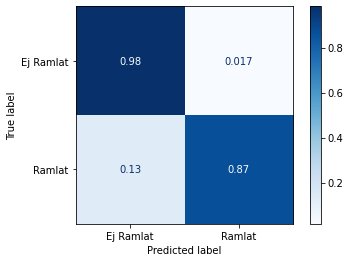

In [11]:
# Needed for the confusion matrix
class_names = ["Ej Ramlat", "Ramlat"]
disp = metrics.plot_confusion_matrix(clf, x_valid, y_valid, 
                                     display_labels=class_names, 
                                     cmap=plt.cm.Blues,normalize='true');

print("Score:")
print("acc: ", round(accuracy_score(y_true=y_valid, y_pred=y_pred), 4))
print("prec: ", round(precision_score(y_true=y_valid, y_pred=y_pred), 4))
print("rec: ", round(recall_score(y_true=y_valid, y_pred=y_pred), 4))
print("f1:  ", round(f1_score(y_true=y_valid, y_pred=y_pred), 4))

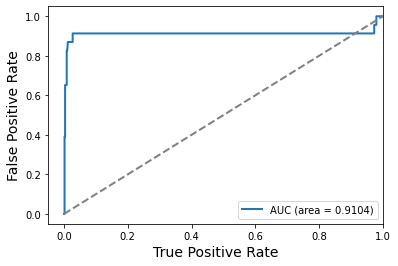

In [12]:
plot_roc_curve(y_valid, y_prob)

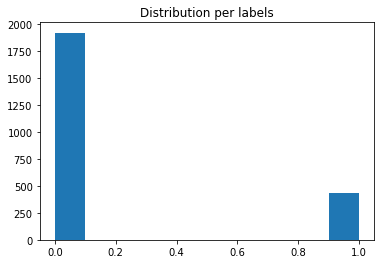

In [13]:
plt.figure()
plt.title("Distribution per labels")
plt.hist(y_train);

### Discuss actual result

![Confusion matrix](03_images/confusion_matrix_real_data.png)   
![AUC plot](03_images/auc_plot_real_data.png)   
![Label distribution](03_images/label_distribution_real_data.png)   


## Train and evaluate the models
We use *K-Fold Cross Validation* for the different models in order to compare their performance on the dataset. 

In [32]:
indices = (train_indices
           .append(test_indices)
           .append(valid_indices))

X = df[feature].values[indices]
y = df[target].values[indices]


k = 5
k_fold = KFold(n_splits=k, random_state=None)
clf = SVC(kernel='linear', probability=True, random_state=42)
X = features.fit_transform(X)

Avg accuracy: 0.9862788192199957
[0.98461538 0.98739496 0.99579832 0.98319328 0.98039216]


In [ ]:
result = cross_val_score(clf , X, y, cv = k_fold)
print("Avg accuracy: {}".format(result.mean()))
print(result)

In [ ]:
train

## Best

In [14]:
print(train_indices)
print(valid_indices)
print(test_indices)

Int64Index([  94,  182,  230,  238,  283,  285,  314,  365,  499,  522,
            ...
            6138, 6141, 6144, 6149, 6154, 6159, 6161, 6167, 6173, 6176],
           dtype='int64', length=2358)
Int64Index([   7,   17,   19,   66,   68,   98,  111,  114,  116,  118,
            ...
            6153, 6166, 6168, 6182, 6190, 6193, 6194, 6225, 6234, 6244],
           dtype='int64', length=613)
Int64Index([   8,   13,   20,   27,   38,   52,   70,   72,   89,  103,
            ...
            6142, 6145, 6146, 6184, 6192, 6207, 6218, 6229, 6233, 6243],
           dtype='int64', length=623)


In [17]:
sum(df.label)

267

In [ ]:
# Extreme! 
# Oversample positive examples

In [ ]:
df = pd.read_csv("../data/df_to_predict_fall_injuries.csv")

split = ["train", "valid", "test"]
split_probability = [.9, .1, 0]

if "Set" not in df.columns:
    # 205, 17, 22 fall injuries in each
    df["Set"] = np.random.choice(split, 
                                 p=split_probability, 
                                 size=(df.shape[0],))

# concatinate all the features
df["text_with_features"] = df.apply(lambda x: \
              ("gender: " + ("Man" if x.gender == 1 else "Kvinna") + ". "  \
               + "age: "  + str(x.age)  + ". " \
               + "time: " + str(x.time) + ". " \
               + x.text), axis=1)
    
train_indices = df[df.Set=="train"].index
valid_indices = df[df.Set=="valid"].index
test_indices = df[df.Set=="test"].index

# reduce train set from 5000 non-falls to about 1500 non-falls
tt = df.loc[train_indices]
train_indices_zeros = tt[tt.label == 0].index 
train_indices_ones = tt[tt.label == 1].index
train_indices = train_indices_ones.append(train_indices_zeros)
# then add more fall injuries
for _ in range(10):
    train_indices = train_indices.append(train_indices_ones)

# Set the features and target label
target = 'label'
feature = 'text_with_features'

x_train = df[feature].values[train_indices]
y_train = df[target].values[train_indices]

x_valid = df[feature].values[valid_indices]
y_valid = df[target].values[valid_indices]

x_test = df[feature].values[test_indices]
y_test = df[target].values[test_indices]

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve

#train = pd.read_csv('../data/rh_train.csv')
#valid = pd.read_csv('../data/rh_test.csv')
#x_train, y_train = train['text'], train['label']
#x_valid, y_valid = valid['text'], valid['label']

char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, norm='l2',
                                  analyzer='char', smooth_idf=True,
                                  sublinear_tf=True)
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True, norm='l2',
                                  analyzer='word', smooth_idf=True,
                                  sublinear_tf=True)

features = FeatureUnion([
    ('words', word_vectorizer),
    ('chars', char_vectorizer),
])

# clf = LinearSVC(C=1.0, random_state=42)
clf = SVC(kernel='linear', probability=True, random_state=42)
# clf = RandomForestClassifier(n_estimators=1000, random_state=42)


x_train = features.fit_transform(x_train)
x_valid = features.transform(x_valid)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_valid)
y_prob = clf.predict_proba(x_valid)

# Needed for the confusion matrix
class_names = ["Ej Ramlat", "Ramlat"]
disp = metrics.plot_confusion_matrix(clf, x_valid, y_valid, display_labels=class_names, cmap=plt.cm.Blues,normalize='true');

print("Score:")
print("acc: ", round(accuracy_score(y_true=y_valid, y_pred=y_pred), 4))
print("prec: ", round(precision_score(y_true=y_valid, y_pred=y_pred), 4))
print("rec: ", round(recall_score(y_true=y_valid, y_pred=y_pred), 4))
print("f1:  ", round(f1_score(y_true=y_valid, y_pred=y_pred), 4))

In [ ]:
# Store the patients the model predicts hav had a fall injurie
df_pred = valid.copy(deep=True)
df_pred['label'] = y_pred
df_pred['label'] = pd.to_numeric(df_pred["label"], downcast='integer')
predicted_pos = df_pred[df_pred.label == 1]
#predicted_pos.to_csv("../data/pred_pos_SVC_2017.csv")
#svc_pos = predicted

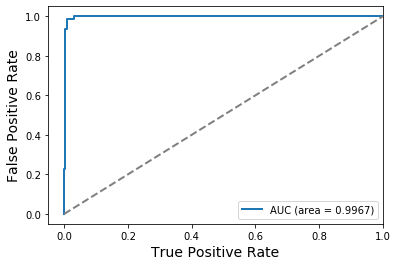

In [539]:
plot_roc_curve(y_valid, y_prob, figure_name="SVC_ROC.png")

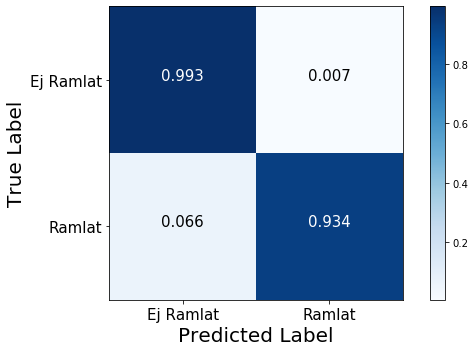

In [540]:
plot_confusion_matrix(cm=disp.confusion_matrix, class_names=class_names, figure_name="SVC_confusion_matrix.png", title="")

In [541]:
# Random Forest with TFIDF

Score:
acc:  0.9477
prec:  0.9565
rec:  0.7213
f1:   0.8224


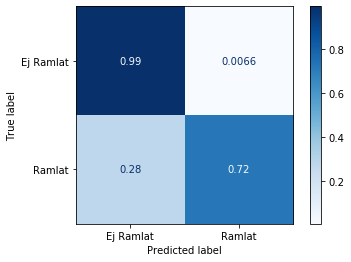

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

train = pd.read_csv('../data/rh_train.csv')
valid = pd.read_csv('../data/rh_test.csv')
x_train, y_train = train['text'], train['label']
x_valid, y_valid = valid['text'], valid['label']

char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, norm='l2',
                                  analyzer='char', smooth_idf=True,
                                  sublinear_tf=True)
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), use_idf=True, norm='l2',
                                  analyzer='word', smooth_idf=True,
                                  sublinear_tf=True)

features = FeatureUnion([
    ('words', word_vectorizer),
    # ('chars', char_vectorizer),
])

# clf = LinearSVC(C=1.0, random_state=42)
# clf = SVC(kernel='linear', probability=True, random_state=42)
clf = RandomForestClassifier(n_estimators=1000, random_state=42)


x_train = features.fit_transform(x_train)
x_valid = features.transform(x_valid)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_valid)
y_prob = clf.predict_proba(x_valid)

# Needed for the confusion matrix
class_names = ["Ej Ramlat", "Ramlat"]
disp = metrics.plot_confusion_matrix(clf, x_valid, y_valid, display_labels=class_names, cmap=plt.cm.Blues,normalize='true');

print("Score:")
print("acc: ", round(accuracy_score(y_true=y_valid, y_pred=y_pred), 4))
print("prec: ", round(precision_score(y_true=y_valid, y_pred=y_pred), 4))
print("rec: ", round(recall_score(y_true=y_valid, y_pred=y_pred), 4))
print("f1:  ", round(f1_score(y_true=y_valid, y_pred=y_pred), 4))

# Store the patients the model predicts hav had a fall injurie
df_pred = valid.copy(deep=True)
df_pred['label'] = y_pred
df_pred['label'] = pd.to_numeric(df_pred["label"], downcast='integer')
predicted_pos = df_pred[df_pred.label == 1]
#predicted_pos.to_csv("../data/pred_pos_RF_2017.csv")
#svc_pos = predicted

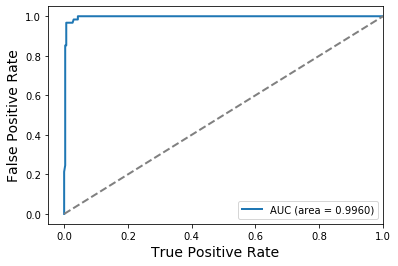

In [543]:
plot_roc_curve(y_valid, y_prob, figure_name="RF_ROC.png")

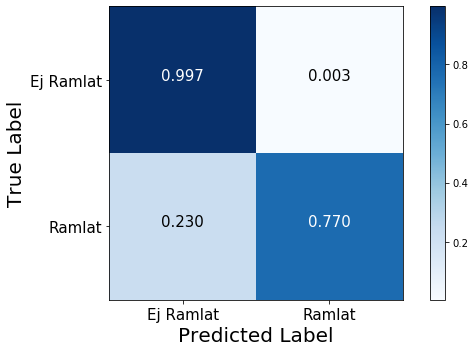

In [544]:
plot_confusion_matrix(cm=disp.confusion_matrix, class_names=class_names, figure_name="RF_confusion_matrix.png", title="")

# Predict on 2017 data

## TF-IDF with SVC (Best Baseline)

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_score


train = pd.read_csv('../data/rh_train.csv')
valid = pd.read_csv('../data/test_2017.csv')
train_x, train_y = train['text'], train['label']
valid_x, valid_y = valid['text'], valid['label']

char_vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, norm='l2',
                                  analyzer='char', smooth_idf=True,
                                  sublinear_tf=True)
word_vectorizer = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, norm='l2',
                                  analyzer='word', smooth_idf=True,
                                  sublinear_tf=True)

features = FeatureUnion([
    ('words', word_vectorizer),
    ('chars', char_vectorizer),
])

pipeline = make_pipeline(features, LinearSVC(C=1.0))
pipeline.fit(train_x, train_y)

predicted = pipeline.predict(valid_x)

# Get which ids predicted positive fall injuries and view those
df_pred = valid.copy(deep=True)
df_pred['label'] = predicted
df_pred['label'] = pd.to_numeric(df_pred["label"], downcast='integer')

predicted_pos = df_pred[df_pred.label == 1]
predicted_pos.to_csv("../data/pred_pos_SVC_2017.csv")
svc_pos = predicted

In [526]:
metrics.auc

<function sklearn.metrics._ranking.auc(x, y)>

In [536]:
metrics.roc_auc_score(np.array(y_valid), y_prob[:, 1])

0.9960102051894474

# Predict Fall Injuries for 2017

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

train = pd.read_csv('../data/rh_train_2016_all.csv')
valid = pd.read_csv('../data/test_2017.csv')
train_x, train_y = train['text'], train['label']
valid_x, valid_y, valid_id = valid['text'], valid['label'], valid['id']

word_vectorizer = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, norm='l2',
                                  analyzer='word', smooth_idf=True,
                                  sublinear_tf=True)

features = FeatureUnion([
    ('words', word_vectorizer),
])

clf = make_pipeline(features, RandomForestClassifier(n_estimators=1000))
clf.fit(train_x, train_y)

predicted = pipeline.predict(valid_x)

# Get which ids predicted positive fall injuries and view those
df_pred = valid.copy(deep=True)
df_pred['label'] = predicted
df_pred['label'] = pd.to_numeric(df_pred["label"], downcast='integer')

predicted_pos = df_pred[df_pred.label == 1]
predicted_pos.to_csv("../data/pred_pos_RF_2017.csv")
rf_pos = predicted

In [87]:
# plot the feature importance of each word
assert(len(word_vectorizer.get_feature_names()) == len(pipeline[1][1].feature_importances_))
feature_importance = pd.Series(pipeline.steps[1][1].feature_importances_ , index=word_vectorizer.get_feature_names())
feature_importance.nlargest(20).plot(kind="bar", figsize=(10,10), title="Ordvikt av de 20 vanligaste / fallskade-prediktion")

In [114]:
print(sum(svc_pos))
print(sum(rf_pos))
print()

905.0
562.0



In [89]:
print(sum(predicted), "/", len(predicted))

551.0 / 208614


In [124]:
# Save to Excel

pos_svc = pd.read_csv("../data/pred_pos_SVC_2017.csv")
pos_rf = pd.read_csv("../data/pred_pos_RF_2017.csv")
pos_bert = pd.read_csv("../data/pred_pos_bert_2017.csv")

In [125]:
pos_bert

,Unnamed: 0,Unnamed: 0.1,Patient_ID,year,id,text,label
0,38,38,100,2017,410,Kissat på bäcken ua.,1
1,95,95,100,2017,474,Ortopedjouren är hos patienten och punkterar o...,1
2,118,118,102,2017,540,Enligt SKL´s patientsäkerhet-fall föreligger r...,1
3,294,294,461,2017,2266,Kissat på toaletten.,1
4,509,509,614,2017,3785,Ringer på klockan för hjälp men går upp själv ...,1
...,...,...,...,...,...,...,...
2365,208336,208336,853375,2017,2336873,Har för tre måndaer sedan spelat innebandy och...,1
2366,208355,208355,853643,2017,2336892,"Sovit sittande på golvet, lutande mot väggen.",1
2367,208394,208394,853643,2017,2336968,Plötslig huvudvärk hemma. Anhöriga ringer ambu...,1
2368,208456,208456,854818,2017,2337533,Pat fick ett skarapsår på ryggen efter ett toa...,1


In [122]:
df = pd.read_csv("../data/rh_data.csv")
df

,Unnamed: 0,omv_pk,Patient_ID,Inpatient_Admissiondatetime,Inpatient_Departure,omvantDT,sokkod,omvtext_concat,Class_2016
0,0,114730_2_S_1_1_Hjkä,5,2010-06-13 08:00:00.000,2010-06-16 17:00:00.000,2010-06-13 13:00:00,Hjkä,Telemetri har efter digitalisering nr 2 gått i...,NaN
1,1,114730_1_S_1_1_Välb,5,2010-06-13 08:00:00.000,2010-06-16 17:00:00.000,2010-06-14 15:00:00,Välb,"Ej kräkts eller mått illa idag, ingen smärta. ...",NaN
2,2,114730_1_S_1_1_Rond,5,2010-06-13 08:00:00.000,2010-06-16 17:00:00.000,2010-06-15 13:00:00,Rond,Patienten skall på en CT - buk klockan 14.30 s...,NaN
3,3,456110_1_S_3_1_Välb,7,2012-03-27 12:00:00.000,2012-03-28 15:00:00.000,2012-03-27 20:00:00,Välb,Patienten lite irriterad vid ankomsten till av...,NaN
4,4,456110_1_S_3_1_Smär,7,2012-03-27 12:00:00.000,2012-03-28 15:00:00.000,2012-03-28 06:00:00,Smär,"Besväras av sin värk i ryggen samt arm, får sm...",NaN
...,...,...,...,...,...,...,...,...,...
2351343,2351343,809104_1_S_7_1_Hud,952471,2020-12-13 10:00:00.000,2020-12-13 23:00:00.000,2020-12-13 13:00:00,Hud,Små skrubbsår över hela kroppen.,NaN
2351344,2351344,809104_2_S_7_1_Komm,952471,2020-12-13 10:00:00.000,2020-12-13 23:00:00.000,2020-12-13 20:00:00,Komm,RLS 4 -> 2. Minns ej vad som hänt. \n Lugn i ...,NaN
2351345,2351345,809104_2_S_7_1_Sast,952471,2020-12-13 10:00:00.000,2020-12-13 23:00:00.000,2020-12-13 23:00:00,Sast,Pat är färdigvårdad på medicin/IVA och är välk...,NaN
2351346,2351346,809104_2_S_7_1_Nut,952471,2020-12-13 10:00:00.000,2020-12-13 23:00:00.000,2020-12-13 20:00:00,Nut,Iv vätska. Elektrolyter ok. \n Mkt hungrig.,NaN


In [158]:
# From predicted model, get the correct ID/category RH wants
def get_rh_id_from_predictions(df, df_predicted_fall_injuries):
    """Get the correct ID (omv_pk) from the dataset from the predicted fall injuries models."""
    d = df.iloc[df_predicted_fall_injuries['id']]
    return d[['omv_pk']].copy(deep=True)


id_svc = get_rh_id_from_predictions(df, pos_svc)
id_rf = get_rh_id_from_predictions(df, pos_rf)
id_bert = get_rh_id_from_predictions(df, pos_bert)

In [185]:
# Save to excel
with pd.ExcelWriter('rh_pred_fall_injuries_2017.xls') as writer:
    id_svc.to_excel(writer, index=False, sheet_name="best_baseline")
    id_rf.to_excel(writer, index=False, sheet_name="explainable_baselin")
    id_bert.to_excel(writer, index=False, sheet_name="swedish_bert")

In [188]:
# To read a Excel document again
xls = pd.ExcelFile('rh_pred_fall_injuries_2017.xls')
#pd.read_excel(xls, "best_baseline_tfidf_SVC")
#pd.read_excel(xls, "explainable_baseline_tfidf_randomforest")
pd.read_excel(xls, "swedish_bert")

,omv_pk
0,64845_1_S_7_1_Urin
1,64845_5_S_7_1_Förf
2,13721_2_d_5_2_
3,123741_4_S_21_1_Urin
4,75839_1_S_6_1_Förf
...,...
2365,720034_2_S_1_1_Sast
2366,719537_2_S_3_1_Sömn
2367,719537_1_S_1_1_Ivin
2368,721274_6_S_1_1_Sast


In [189]:
!pip install xlwt xlrd openpyxl

You should consider upgrading via the 'C:\Users\mse002\.conda\envs\mental\python.exe -m pip install --upgrade pip' command.


In [10]:
from sklearn.inspection import permutation_importance

permuted_feature_imp = permutation_importance(clf, x_valid.toarray(), y_valid, 
                                              random_state=42 , n_repeats=1,)


KeyboardInterrupt: 

In [4]:
f_idx = clf.feature_importances_.argsort()[::-1][:16] # sort assending
f = clf.feature_importances_
words = features.get_feature_names()
ww  = [words[i].split("words__")[-1] for i in f_idx]
ff = f[f_idx]


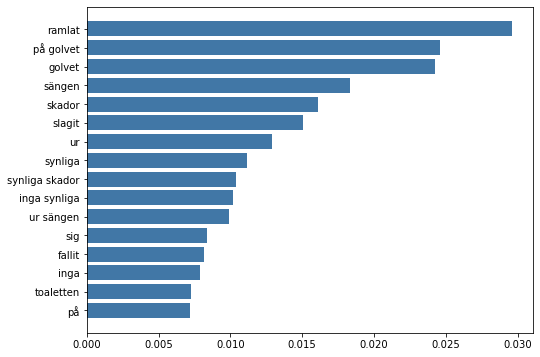

In [60]:
plt.figure(figsize=(8, 6))
plt.barh(ww, ff, color="#4177a6")
plt.gca().invert_yaxis()
plt.savefig("RF_feature_extraction.png")

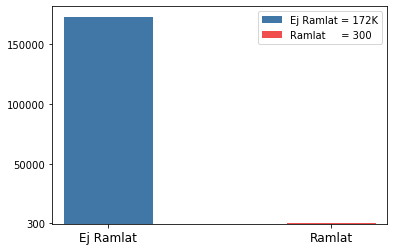

In [500]:
neg = df[df.Class_2016 == 0.0].Class_2016
pos = df[df.Class_2016 == 1.0].Class_2016

plt.figure()
plt.hist(neg, label="Ej Ramlat = {}K".format(len(neg)//1000), width=0.4, color="#4177a6")
plt.hist(pos, label="Ramlat     = {}".format(len(pos)), width=0.4, color="#f04e4c")
plt.xlim([-0.05, 1.45])
plt.xticks([0.2, 1.2], ["Ej Ramlat", "Ramlat"], fontsize=12)
plt.yticks([300, 50000, 100000, 150000])
plt.legend()
plt.savefig("2016_class_imbalance.png")

In [501]:
pos_svc = pd.read_csv("../data/pred_pos_SVC_2017.csv")
pos_rf = pd.read_csv("../data/pred_pos_RF_2017.csv")
pos_bert = pd.read_csv("../data/pred_pos_bert_2017.csv")

In [502]:
len(pos_bert), len(pos_svc), len(pos_rf)

(2370, 905, 562)

In [506]:
neg = df[df.Class_2016 == 0.0].Class_2016
pos = df[df.Class_2016 == 1.0].Class_2016

plt.figure()
plt.hist(neg, label="Ej Ramlat = {}K".format(len(neg)//1000), width=0.4, color="#4177a6")
plt.hist(pos, label="Ramlat     = {}".format(len(pos)), width=0.4, color="#f04e4c")
plt.xlim([-0.05, 1.45])
plt.xticks([0.2, 1.2], ["Ej Ramlat", "Ramlat"], fontsize=12)
plt.yticks([300, 50000, 100000, 150000])
plt.legend()

array([0., 0., 1., ..., 0., 0., 0.])

(array([302.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  61.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

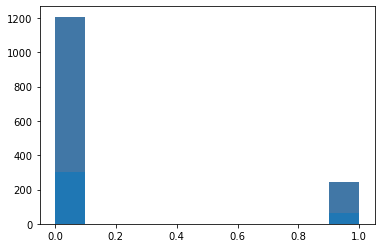

In [521]:
plt.hist(train.label, color="#4177a6")
plt.hist(valid.label

In [520]:
words = []
for w in df.text_with_features:
    words.append(len(w))
    
max_char_len = 200
avg_chars = sum(words)/len(words)
# avegage word lenght is 5 char so estimate
max_word_len = max_char_len/5
avg_words = avg_chars/5

print(avg_words)
print(max_word_len)

17.94370033921028
40.0


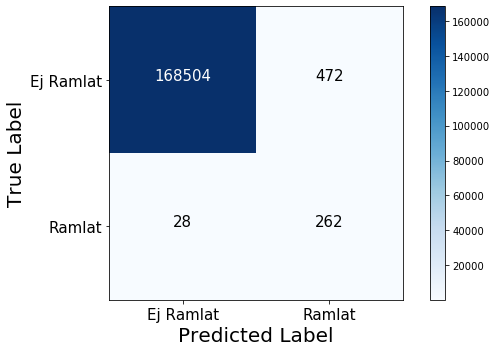

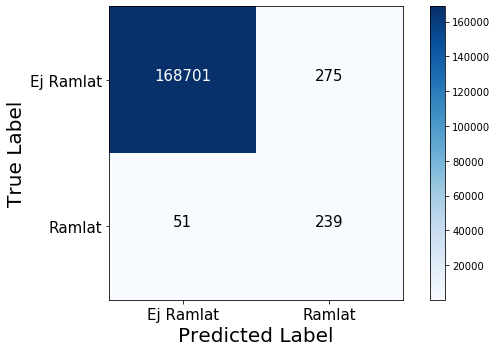

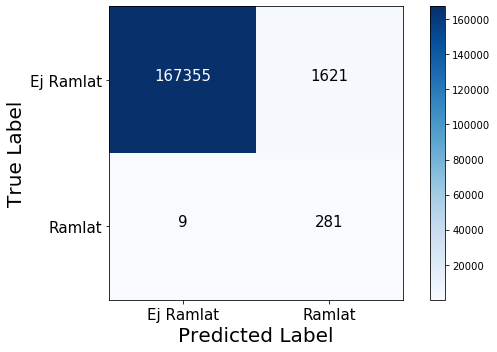

In [567]:
# SVC 2017 test
import numpy as np
import itertools

# SVC
plot_confusion_matrix(cm=np.array([[168504, 472], [28, 262]]), class_names=class_names, normalized=False, figure_name="SCV_2017.png")

# RF
plot_confusion_matrix(cm=np.array([[168701, 275], [51, 239]])s, class_names=class_names, normalized=False, figure_name="RF_2017.png")
              
# Bert
plot_confusion_matrix(cm=np.array([[167355, 1621], [9, 281]]), class_names=class_names, normalized=False, figure_name="BERT_2017.png")

In [62]:
disp.confusion_matrix

array([[0.99337748, 0.00662252],
       [0.27868852, 0.72131148]])

In [ ]:
sa

In [ ]:
asd